# AlexNET implementation(with some changes) using tensorflow on catsvsdogs dataset. 

In [1]:
import tensorflow as tf
import cv2
import pickle as pk
import os
from tqdm import tqdm
from random import shuffle
import numpy as np
import matplotlib.pyplot as plt

Download data from [http://files.fast.ai/data/dogscats.zip](http://files.fast.ai/data/dogscats.zip)

In [2]:
train_path = "./dogscats/train/"
validation_path = "./dogscats/valid/"

In [3]:
training_data = []
validation_data = []

def insert_data(data_type, dir_path, category):
    for img in tqdm(os.listdir(dir_path+category)):
        path = os.path.join(dir_path+category,img)
        image = cv2.imread(path)
        image = cv2.resize(image, (227, 227))
        label = [1,0] if category=="cats" else [0,1]
        data_type.append([np.array(image), np.array(label)])
        image = cv2.flip(image,1)
        data_type.append([np.array(image), np.array(label)])

insert_data(training_data, train_path, "cats")
insert_data(training_data, train_path, "dogs")
insert_data(validation_data, validation_path, "cats")
insert_data(validation_data, validation_path, "dogs")

shuffle(training_data)
shuffle(validation_data)


train_x = []
train_y = []
val_x = []
val_y = []

for i in range(len(training_data)):
    train_x.append(training_data[i][0])
    train_y.append(training_data[i][1])
    

for i in range(len(validation_data)/2):
    val_x.append(validation_data[i][0])
    val_y.append(validation_data[i][1])
    
train_x = np.array(train_x)
train_y = np.array(train_y)
val_x = np.array(val_x)
val_y = np.array(val_y)

n_train = train_x.shape[0]
n_val = val_x.shape[0]

print train_x.shape 
print train_y.shape 
print val_x.shape
print val_y.shape

100%|██████████| 1000/1000 [00:01<00:00, 502.64it/s]


(46000, 227, 227, 3)
(46000, 2)
(2000, 227, 227, 3)
(2000, 2)


In [4]:
def forward_pass(x, keep_rate):
    init = tf.contrib.layers.xavier_initializer(seed=0)
    conv1_w = tf.get_variable("conv1_w", [11,11,3,96], initializer=init)
    conv2_w = tf.get_variable("conv2_w", [5,5,96,256], initializer=init)
    conv3_w = tf.get_variable("conv3_w", [3,3,256,384], initializer=init)
    conv4_w = tf.get_variable("conv4_w", [3,3,384,384], initializer=init)
    conv5_w = tf.get_variable("conv5_w", [3,3,384,256], initializer=init)
    fc6_w = tf.get_variable("fc6_w", [9216,4096], initializer=init)
    fc7_w = tf.get_variable("fc7_w", [4096,4096], initializer=init)
    out_w = tf.get_variable("out_w", [4096,n_classes], initializer=init)
    
    
    conv1 = tf.nn.relu(tf.nn.conv2d(x,conv1_w,strides=[1,4,4,1], padding="VALID"))
    conv1 = tf.nn.max_pool(conv1, ksize=[1,3,3,1], strides=[1,2,2,1], padding="VALID")
    
    conv2 = tf.nn.relu(tf.nn.conv2d(conv1,conv2_w,strides=[1,1,1,1], padding="SAME"))
    conv2 = tf.nn.max_pool(conv2, ksize=[1,3,3,1], strides=[1,2,2,1], padding="VALID")
    
    conv3 = tf.nn.relu(tf.nn.conv2d(conv2,conv3_w,strides=[1,1,1,1], padding="SAME"))
    
    conv4 = tf.nn.relu(tf.nn.conv2d(conv3,conv4_w,strides=[1,1,1,1], padding="SAME"))
    
    conv5 = tf.nn.relu(tf.nn.conv2d(conv4,conv5_w,strides=[1,1,1,1], padding="SAME"))
    conv5 = tf.nn.max_pool(conv5, ksize=[1,3,3,1], strides=[1,2,2,1], padding="VALID")
    conv5 = tf.contrib.layers.flatten(conv5)
    
    fc6 = tf.contrib.layers.fully_connected(conv5, 4096, activation_fn=tf.nn.relu)
    fc6 = tf.nn.dropout(fc6, keep_rate)
    
    fc7 = tf.contrib.layers.fully_connected(fc6, 4096, activation_fn=tf.nn.relu)
    fc7 = tf.nn.dropout(fc7, keep_rate)
    
    out = tf.contrib.layers.fully_connected(fc6, n_classes, activation_fn=None)
    
    return out

In [5]:
tf.reset_default_graph()
training_loss=[]
validation_acc=[]
epoch=[]

with tf.Session() as sess:
    np.random.seed(1)
    n_classes = 2
    batch_size = 512
    n_epochs = 20
    x = tf.placeholder('float', [None, 227, 227, 3])
    y = tf.placeholder('float', [None, n_classes])
    keep_rate = 0.8
    keep_prob = tf.placeholder(tf.float32)
    out = forward_pass(x, keep_rate)
    cost = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits(logits=out,labels=y) )
    optimizer = tf.train.AdamOptimizer(learning_rate=0.0005).minimize(cost)
    init = tf.global_variables_initializer()
    sess.run(init)
    for e in range(n_epochs):
        loss = 0
        n_batch = 0
        if(n_train%batch_size==0):
            n_batch = n_train/batch_size
        else:
            n_batch = n_train/batch_size + 1
        for i in range(n_batch):
            sub_train_x = train_x[i*batch_size:min([(i+1)*batch_size-1, n_train-1]), : , : , :]
            sub_train_y = train_y[i*batch_size:min([(i+1)*batch_size-1, n_train-1]), : ]
            _, a = sess.run([optimizer,cost], feed_dict = {x: sub_train_x, y: sub_train_y})
            loss = loss + a
        correct = tf.equal(tf.argmax(out, 1), tf.argmax(y, 1))
        accuracy = tf.reduce_mean(tf.cast(correct, 'float')).eval({x:val_x, y:val_y})
        print "Epoch", e+1,"completed. Loss :", loss, '. Accuracy:',accuracy
        training_loss.append(loss)
        validation_acc.append(accuracy)
        epoch.append(e+1)
    

Epoch 1 completed. Loss : 1844.46574897 . Accuracy: 0.6205
Epoch 2 completed. Loss : 57.934242785 . Accuracy: 0.681
Epoch 3 completed. Loss : 58.2142119408 . Accuracy: 0.6715
Epoch 4 completed. Loss : 52.4944075346 . Accuracy: 0.7325
Epoch 5 completed. Loss : 48.230666697 . Accuracy: 0.7605
Epoch 6 completed. Loss : 43.7977248132 . Accuracy: 0.781
Epoch 7 completed. Loss : 39.8038985729 . Accuracy: 0.795
Epoch 8 completed. Loss : 36.748244971 . Accuracy: 0.7845
Epoch 9 completed. Loss : 33.9295793176 . Accuracy: 0.8095
Epoch 10 completed. Loss : 31.8555585742 . Accuracy: 0.7865
Epoch 11 completed. Loss : 30.6761318445 . Accuracy: 0.8135
Epoch 12 completed. Loss : 26.9845447838 . Accuracy: 0.8345
Epoch 13 completed. Loss : 25.17966941 . Accuracy: 0.827
Epoch 14 completed. Loss : 23.9187817872 . Accuracy: 0.836
Epoch 15 completed. Loss : 22.0361822098 . Accuracy: 0.837
Epoch 16 completed. Loss : 22.8422606885 . Accuracy: 0.7875
Epoch 17 completed. Loss : 20.7857697904 . Accuracy: 0.845
E

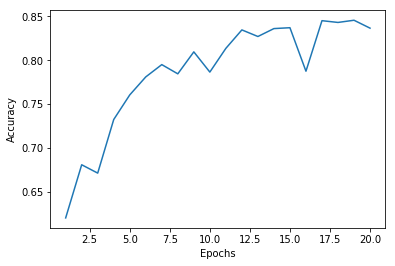

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(epoch, validation_acc)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")



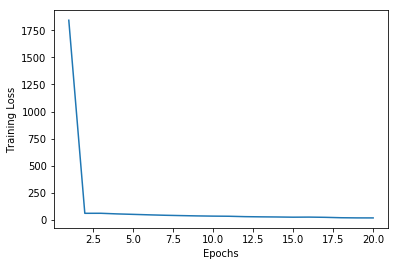

In [11]:
plt.plot(epoch, training_loss)
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
